# ✅ 모델 6: CCTV 설치밀도 vs 범죄유형별 발생률 분석

In [1]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings
import optuna

# 경고 메시지 무시
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# 범죄 데이터 로드 - 필요한 행을 건너뛰고 로드
crime_data_1 = pd.read_excel("../../dataset/범죄안전데이터/112 신고출동 현황/22년상반기.xlsx", skiprows=4)
crime_data_2 = pd.read_excel("../../dataset/범죄안전데이터/112 신고출동 현황/22년하반기.xlsx", skiprows=4)

# 데이터 확인
print("상반기 데이터 구조:")
print(crime_data_1.shape)
print(crime_data_1.columns.tolist())
print(crime_data_1.head())

# 필요없는 행 제거 (합계, 서울청 등)
crime_data_1 = crime_data_1[~crime_data_1.iloc[:, 1].isin(['합계', '서울청'])]
crime_data_1 = crime_data_1[crime_data_1.iloc[:, 1].notna()]
crime_data_2 = crime_data_2[~crime_data_2.iloc[:, 1].isin(['합계', '서울청'])]
crime_data_2 = crime_data_2[crime_data_2.iloc[:, 1].notna()]

# 컬럼명 설정
column_names = ['시도청', '경찰서명', '접수코드', '전체신고건수', 'C0_신고건수', 'C1_신고건수', 'C2_신고건수', 'C3_신고건수', 'C4_신고건수']
crime_data_1.columns = column_names
crime_data_2.columns = column_names

# 데이터 병합
crime_data = pd.concat([crime_data_1, crime_data_2])

# 경찰서 목록 확인
print("\n경찰서 목록:")
print(crime_data['경찰서명'].unique())

상반기 데이터 구조:
(34, 9)
['합계', '합계.1', '합계.2', 1913908, 15446, 335148, 733010, 88314, 741990]
    합계    합계.1 합계.2  1913908  15446  335148  733010  88314  741990
0  서울청      합계   합계  1913908  15446  335148  733010  88314  741990
1  NaN     서울청   합계   634325    500   15458   11717   2772  603878
2  NaN  지하철경찰대   합계        9      0       7       1      1       0
3  NaN   서울중부서   합계    23331    223    5359   14014   1548    2187
4  NaN   서울종로서   합계    25035    262    5113   15136   1829    2695

경찰서 목록:
['지하철경찰대' '서울중부서' '서울종로서' '서울남대문서' '서울서대문서' '서울혜화서' '서울용산서' '서울성북서'
 '서울동대문서' '서울마포서' '서울영등포서' '서울성동서' '서울동작서' '서울광진서' '서울서부서' '서울강북서' '서울금천서'
 '서울중랑서' '서울강남서' '서울관악서' '서울강서서' '서울강동서' '서울종암서' '서울구로서' '서울서초서' '서울양천서'
 '서울송파서' '서울노원서' '서울방배서' '서울은평서' '서울도봉서' '서울수서서']


In [3]:
# 경찰서를 자치구로 매핑
police_district_mapping = {
    '서울중부서': '중구', '중부서': '중구',
    '서울종로서': '종로구', '종로서': '종로구',
    '서울남대문서': '중구', '남대문서': '중구',
    '서울서대문서': '서대문구', '서대문서': '서대문구',
    '서울혜화서': '종로구', '혜화서': '종로구',
    '서울용산서': '용산구', '용산서': '용산구',
    '서울성북서': '성북구', '성북서': '성북구',
    '서울동대문서': '동대문구', '동대문서': '동대문구',
    '서울마포서': '마포구', '마포서': '마포구',
    '서울영등포서': '영등포구', '영등포서': '영등포구',
    '서울성동서': '성동구', '성동서': '성동구',
    '서울동작서': '동작구', '동작서': '동작구',
    '서울광진서': '광진구', '광진서': '광진구',
    '서울송파서': '송파구', '송파서': '송파구',
    '서울강동서': '강동구', '강동서': '강동구',
    '서울강남서': '강남구', '강남서': '강남구',
    '서울서초서': '서초구', '서초서': '서초구',
    '서울강서서': '강서구', '강서서': '강서구',
    '서울양천서': '양천구', '양천서': '양천구',
    '서울구로서': '구로구', '구로서': '구로구',
    '서울금천서': '금천구', '금천서': '금천구',
    '서울관악서': '관악구', '관악서': '관악구',
    '서울강북서': '강북구', '강북서': '강북구',
    '서울도봉서': '도봉구', '도봉서': '도봉구',
    '서울노원서': '노원구', '노원서': '노원구',
    '서울중랑서': '중랑구', '중랑서': '중랑구',
    '지하철경찰대': None
}

# 경찰서 데이터를 자치구 데이터로 변환
crime_data['자치구명'] = crime_data['경찰서명'].map(police_district_mapping)

# 결측값 확인 및 제거
print(f"자치구명 결측값 개수: {crime_data['자치구명'].isna().sum()}")
crime_data = crime_data.dropna(subset=['자치구명'])

# 범죄 유형 재구성 (long format으로 변환)
crime_melted = pd.melt(
    crime_data, 
    id_vars=['경찰서명', '자치구명', '전체신고건수'], 
    value_vars=['C0_신고건수', 'C1_신고건수', 'C2_신고건수', 'C3_신고건수', 'C4_신고건수'],
    var_name='범죄유형', 
    value_name='발생건수'
)

# 범죄 유형 이름 변경
crime_melted['범죄유형'] = crime_melted['범죄유형'].str.replace('_신고건수', '')
crime_melted['범죄유형'] = crime_melted['범죄유형'].map({
    'C0': '긴급신고(생명/신체위험)',
    'C1': '범죄신고(폭력/강도/절도)',
    'C2': '교통신고(사고/위반)',
    'C3': '질서유지(가정폭력/주취자)',
    'C4': '기타신고(분실/고장)'
})

# 데이터 타입 변환
crime_melted['발생건수'] = pd.to_numeric(crime_melted['발생건수'], errors='coerce')
crime_melted['발생건수'] = crime_melted['발생건수'].fillna(0)

# 자치구별, 범죄 유형별 집계
crime_by_district = crime_melted.groupby(['자치구명', '범죄유형']).sum(numeric_only=True).reset_index()
print("\n자치구별, 범죄유형별 발생 건수 (일부):")
print(crime_by_district.head(10))

# 피벗 테이블 생성 (자치구 x 범죄유형)
crime_pivot = crime_by_district.pivot_table(
    index='자치구명', 
    columns='범죄유형', 
    values='발생건수',
    aggfunc='sum'
).reset_index()

print("\n자치구별 범죄 유형별 피벗 테이블:")
print(crime_pivot.head())

자치구명 결측값 개수: 12

자치구별, 범죄유형별 발생 건수 (일부):
  자치구명            범죄유형  전체신고건수   발생건수
0  강남구     교통신고(사고/위반)  136781  78382
1  강남구     기타신고(분실/고장)  136781  14526
2  강남구   긴급신고(생명/신체위험)  136781   2065
3  강남구  범죄신고(폭력/강도/절도)  136781  32072
4  강남구  질서유지(가정폭력/주취자)  136781   9736
5  강동구     교통신고(사고/위반)  105401  58234
6  강동구     기타신고(분실/고장)  105401  10800
7  강동구   긴급신고(생명/신체위험)  105401   1538
8  강동구  범죄신고(폭력/강도/절도)  105401  28663
9  강동구  질서유지(가정폭력/주취자)  105401   6166

자치구별 범죄 유형별 피벗 테이블:
범죄유형 자치구명  교통신고(사고/위반)  기타신고(분실/고장)  긴급신고(생명/신체위험)  범죄신고(폭력/강도/절도)  \
0     강남구        78382        14526           2065           32072   
1     강동구        58234        10800           1538           28663   
2     강북구        53266         8650           1125           22089   
3     강서구        78172        16271           1347           35512   
4     관악구        78236        18245           1929           37509   

범죄유형  질서유지(가정폭력/주취자)  
0               9736  
1               6166  
2               5146  
3      

In [4]:
# CCTV 데이터 로드 (일부만 먼저 확인)
try:
    cctv_data_sample = pd.read_excel("../../dataset/위치 데이터/cctv데이터.xlsx", nrows=5)
    print("CCTV 데이터 샘플:")
    print(cctv_data_sample.head())
    print("\nCCTV 데이터 컬럼:")
    print(cctv_data_sample.columns.tolist())
    
    # 전체 데이터 로드
    cctv_data = pd.read_excel("../../dataset/위치 데이터/cctv데이터.xlsx")
    
    # 주소 관련 컬럼 찾기
    address_cols = []
    for col in cctv_data.columns:
        if '주소' in col or '소재지' in col or '위치' in col:
            address_cols.append(col)
    
    print(f"\n주소 관련 컬럼: {address_cols}")
    
    # 자치구명 추출 시도
    if address_cols:
        # 첫 번째 주소 컬럼 사용
        address_col = address_cols[0]
        cctv_data['자치구명'] = cctv_data[address_col].astype(str).str.extract(r'서울특별시\s+([가-힣]+구)')
    else:
        # 관리기관명에서 추출 시도
        if '관리기관명' in cctv_data.columns:
            cctv_data['자치구명'] = cctv_data['관리기관명'].astype(str).str.extract(r'([가-힣]+구)')
    
    # 결측값 확인 및 처리
    print(f"\n자치구명 결측값 개수: {cctv_data['자치구명'].isna().sum()}")
    
    # 자치구별 CCTV 수 집계
    cctv_by_district = cctv_data.groupby('자치구명').size().reset_index(name='cctv_count')
    cctv_by_district = cctv_by_district.dropna(subset=['자치구명'])
    
    print("\n자치구별 CCTV 설치 현황:")
    print(cctv_by_district)
    
except Exception as e:
    print(f"CCTV 데이터 처리 중 오류 발생: {e}")
    
    # 오류 발생 시 샘플 데이터 생성
    print("\n샘플 CCTV 데이터를 생성합니다.")
    cctv_by_district = pd.DataFrame({
        '자치구명': ['강남구', '강동구', '강북구', '강서구', '관악구', '광진구', '구로구', '금천구', 
                   '노원구', '도봉구', '동대문구', '동작구', '마포구', '서대문구', '서초구', 
                   '성동구', '성북구', '송파구', '양천구', '영등포구', '용산구', '은평구', 
                   '종로구', '중구', '중랑구'],
        'cctv_count': [5000, 2000, 1500, 2500, 1800, 2200, 1900, 1400, 
                       2800, 1600, 2000, 1800, 2300, 1700, 3500, 
                       2100, 2000, 3000, 1900, 2500, 2200, 1800, 
                       2200, 2000, 1700]
    })
    print(cctv_by_district)

CCTV 데이터 샘플:
   번호       관리기관명              소재지도로명주소           소재지지번주소 설치목적구분  카메라대수  \
0   1  서울특별시 성동구청          서울특별시 마조로 11   서울특별시 행당동 19-98   교통단속      3   
1   2  서울특별시 성동구청  서울특별시 고산자로 330 (마장동)  서울특별시 마장동 520-10   교통단속      2   
2   3  서울특별시 성동구청       서울특별시 마장로35길 76     서울특별시 마장동 818   교통단속      3   
3   4  서울특별시 성동구청   서울특별시 마장로 325 (마장동)  서울특별시 마장동 767-41   교통단속      3   
4   5  서울특별시 성동구청   서울특별시 마장로 322 (마장동)   서울특별시 마장동 781-1   교통단속      2   

   카메라화소수   촬영방면정보  보관일수     설치연월      관리기관전화번호    WGS84위도     WGS84경도  \
0     200  360도전방면    30  2013-11  02-2286-5878  37.558960  127.040794   
1     200  360도전방면    30  2013-11  02-2286-5878  37.569137  127.037521   
2     200  360도전방면    30  2013-11  02-2286-5878  37.570602  127.042519   
3     200  360도전방면    30  2017-11  02-2286-5878  37.567585  127.044815   
4     200  360도전방면    30  2017-11  02-2286-5878  37.566624  127.043945   

      데이터기준일자  
0  2022-06-24  
1  2022-06-24  
2  2022-06-24  
3  2022-06-24  
4  2022-06-

In [5]:
# 주점 데이터 로드
try:
    bar_data = pd.read_csv("../../dataset/위치 데이터/서울시 유흥주점영업 인허가 정보 1904-2025.csv", encoding='cp949')
    
    print("주점 데이터 샘플:")
    print(bar_data.head())
    print("\n주점 데이터 컬럼:")
    print(bar_data.columns.tolist())
    
    # 주소 컬럼 확인
    address_cols = [col for col in bar_data.columns if '주소' in col or '소재지' in col]
    print(f"\n주소 관련 컬럼: {address_cols}")
    
    # 자치구명 추출
    if '지번주소' in bar_data.columns:
        bar_data['자치구명'] = bar_data['지번주소'].astype(str).str.extract(r'서울특별시\s+([가-힣]+구)')
        
        # 도로명주소에서도 추가 추출 (지번주소에서 추출하지 못한 경우)
        if '도로명주소' in bar_data.columns:
            mask = bar_data['자치구명'].isna()
            bar_data.loc[mask, '자치구명'] = bar_data.loc[mask, '도로명주소'].astype(str).str.extract(r'서울특별시\s+([가-힣]+구)')
    
    # 자치구별 주점 수 집계
    bar_by_district = bar_data.groupby('자치구명').size().reset_index(name='bar_count')
    bar_by_district = bar_by_district.dropna(subset=['자치구명'])
    
    print("\n자치구별 주점 현황:")
    print(bar_by_district)
    
except Exception as e:
    print(f"주점 데이터 처리 중 오류 발생: {e}")
    
    # 오류 발생 시 샘플 데이터 생성
    print("\n샘플 주점 데이터를 생성합니다.")
    bar_by_district = pd.DataFrame({
        '자치구명': ['강남구', '강동구', '강북구', '강서구', '관악구', '광진구', '구로구', '금천구', 
                   '노원구', '도봉구', '동대문구', '동작구', '마포구', '서대문구', '서초구', 
                   '성동구', '성북구', '송파구', '양천구', '영등포구', '용산구', '은평구', 
                   '종로구', '중구', '중랑구'],
        'bar_count': [500, 150, 100, 180, 200, 230, 120, 90, 
                      110, 80, 180, 160, 300, 150, 400, 
                      140, 120, 250, 130, 280, 350, 110, 
                      380, 450, 100]
    })
    print(bar_by_district)

주점 데이터 샘플:
   개방자치단체코드                    관리번호       인허가일자  인허가취소일자  영업상태코드  영업상태명  \
0   3220000  3220000-102-2000-21430  2000-03-18      NaN       1  영업/정상   
1   3090000  3090000-102-2007-00004  2007-12-20      NaN       1  영업/정상   
2   3220000  3220000-102-2001-23481  2001-05-12      NaN       1  영업/정상   
3   3230000  3230000-102-2014-00005  2014-11-28      NaN       1  영업/정상   
4   3150000  3150000-102-2015-00003  2015-10-22      NaN       1  영업/정상   

   상세영업상태코드 상세영업상태명 폐업일자  휴업시작일자  ...  공장판매직종업원수  공장생산직종업원수 건물소유구분명  보증액 월세액  \
0         1      영업  NaN     NaN  ...        NaN        NaN     NaN  NaN NaN   
1         1      영업  NaN     NaN  ...        NaN        NaN     NaN  NaN NaN   
2         1      영업  NaN     NaN  ...        NaN        NaN     NaN  NaN NaN   
3         1      영업  NaN     NaN  ...        NaN        NaN     NaN  NaN NaN   
4         1      영업  NaN     NaN  ...        NaN        NaN     NaN  NaN NaN   

  다중이용업소여부 시설총규모  전통업소지정번호 전통업소주된음식 홈페이지  
0      NaN   N

In [6]:
pop_data = pd.read_excel("../../dataset/인구데이터/등록인구_20250412000902.xlsx")

print("인구 데이터 샘플:")
print(pop_data.head())
print("\n인구 데이터 컬럼:")
print(pop_data.columns.tolist())

인구 데이터 샘플:
   동별(1)  동별(2) 2024 4/4 2024 4/4.1 2024 4/4.2 2024 4/4.3 2024 4/4.4  \
0  동별(1)  동별(2)  세대 (세대)      계 (명)      계 (명)      계 (명)    한국인 (명)   
1  동별(1)  동별(2)       소계         소계         남자         여자         소계   
2     합계     소계  4482063    9597372    4619963    4977409    9331828   
3    NaN    종로구    72166     149608      71365      78243     138336   
4    NaN     중구    64995     131214      62924      68290     120544   

  2024 4/4.5 2024 4/4.6 2024 4/4.7 2024 4/4.8 2024 4/4.9 2024 4/4.10  \
0    한국인 (명)    한국인 (명)  등록외국인 (명)  등록외국인 (명)  등록외국인 (명)   세대당인구 (명)   
1         남자         여자         소계         남자         여자          소계   
2    4505355    4826473     265544     114608     150936        2.08   
3      66570      71766      11272       4795       6477        1.92   
4      58015      62529      10670       4909       5761        1.85   

    2024 4/4.11  
0  65세이상고령자 (명)  
1            소계  
2       1824895  
3         29840  
4         26853  

인구 데이터 컬럼:
['동

In [7]:
import pandas as pd

# 엑셀 파일 읽기
excel_path = "../../dataset/인구데이터/등록인구_20250412000902.xlsx"
df = pd.read_excel(excel_path)

# 첫 번째 행을 컬럼명으로 설정
df.columns = df.iloc[0]
df = df.drop(0)

# 두 번째 행을 서브컬럼명으로 설정
sub_columns = df.iloc[0]
df = df.drop(1)

# 컬럼명 정리
df.columns = [
    '구', '동', '세대수', '총인구', '남자인구', '여자인구', 
    '한국인총인구', '한국인남자', '한국인여자', 
    '외국인총인구', '외국인남자', '외국인여자', 
    '세대당인구', '65세이상고령자'
]

# NaN 값 처리
df = df.fillna(method='ffill')

# 숫자형 데이터로 변환
numeric_columns = df.columns[2:]  # 구, 동을 제외한 모든 컬럼
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 결과 출력
print("\n처리된 데이터 샘플:")
print(df.head())

# 기본 통계 정보
print("\n기본 통계 정보:")
print(df.describe()) 


처리된 데이터 샘플:
    구    동      세대수      총인구     남자인구     여자인구   한국인총인구    한국인남자    한국인여자  \
2  합계   소계  4482063  9597372  4619963  4977409  9331828  4505355  4826473   
3  합계  종로구    72166   149608    71365    78243   138336    66570    71766   
4  합계   중구    64995   131214    62924    68290   120544    58015    62529   
5  합계  용산구   103241   217194   104540   112654   203854    97469   106385   
6  합계  성동구   131953   281289   135575   145714   273669   132409   141260   

   외국인총인구   외국인남자   외국인여자  세대당인구  65세이상고령자  
2  265544  114608  150936   2.08   1824895  
3   11272    4795    6477   1.92     29840  
4   10670    4909    5761   1.85     26853  
5   13340    7071    6269   1.97     39407  
6    7620    3166    4454   2.07     51245  

기본 통계 정보:
                세대수           총인구          남자인구          여자인구        한국인총인구  \
count  2.600000e+01  2.600000e+01  2.600000e+01  2.600000e+01  2.600000e+01   
mean   3.447741e+05  7.382594e+05  3.553818e+05  3.828776e+05  7.178329e+05   
std   

In [8]:
import pandas as pd

# 엑셀 파일 읽기
excel_path = "../../dataset/인구데이터/등록인구_20250412000902.xlsx"
df = pd.read_excel(excel_path)

# 첫 번째 행을 컬럼명으로 설정
df.columns = df.iloc[0]
df = df.drop(0)

# 두 번째 행을 서브컬럼명으로 설정
sub_columns = df.iloc[0]
df = df.drop(1)

# 컬럼명 정리
df.columns = [
    '구', '동', '세대수', '총인구', '남자인구', '여자인구', 
    '한국인총인구', '한국인남자', '한국인여자', 
    '외국인총인구', '외국인남자', '외국인여자', 
    '세대당인구', '65세이상고령자'
]

# NaN 값 처리
df = df.fillna(method='ffill')

# 숫자형 데이터로 변환
numeric_columns = df.columns[2:]  # 구, 동을 제외한 모든 컬럼
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 구별 통계 계산
district_stats = df.groupby('구').agg({
    '총인구': 'sum',
    '세대수': 'sum',
    '외국인총인구': 'sum',
    '65세이상고령자': 'sum'
}).reset_index()

# 추가 통계 계산
district_stats['외국인비율'] = (district_stats['외국인총인구'] / district_stats['총인구'] * 100).round(2)
district_stats['고령자비율'] = (district_stats['65세이상고령자'] / district_stats['총인구'] * 100).round(2)
district_stats['세대당인구'] = (district_stats['총인구'] / district_stats['세대수']).round(2)

# 결과 출력
print("\n구별 인구 통계:")
print(district_stats.sort_values('총인구', ascending=False))

# 전체 요약
print("\n서울시 전체 요약:")
total_stats = {
    '총인구': df['총인구'].sum(),
    '세대수': df['세대수'].sum(),
    '외국인비율': (df['외국인총인구'].sum() / df['총인구'].sum() * 100).round(2),
    '고령자비율': (df['65세이상고령자'].sum() / df['총인구'].sum() * 100).round(2),
    '평균세대당인구': (df['총인구'].sum() / df['세대수'].sum()).round(2)
}
for key, value in total_stats.items():
    print(f"{key}: {value:,}") 


구별 인구 통계:
    구       총인구      세대수  외국인총인구  65세이상고령자  외국인비율  고령자비율  세대당인구
0  합계  19194744  8964126  531088   3649790   2.77  19.01   2.14

서울시 전체 요약:
총인구: 19,194,744
세대수: 8,964,126
외국인비율: 2.77
고령자비율: 19.01
평균세대당인구: 2.14


In [9]:
# 인구 데이터 로드
try:
    pop_data = pd.read_excel("../../dataset/인구데이터/등록인구_20250412000902.xlsx")
    
    print("인구 데이터 샘플:")
    print(pop_data.head())
    print("\n인구 데이터 컬럼:")
    print(pop_data.columns.tolist())
    
    # 행정구역 컬럼 확인
    if '행정구역' in pop_data.columns:
        # 행정구역에서 자치구명 추출
        pop_data['자치구명'] = pop_data['행정구역'].astype(str).str.extract(r'([가-힣]+구)')
        
        # 필요한 컬럼만 선택
        if '총인구수' in pop_data.columns:
            pop_by_district = pop_data[['자치구명', '총인구수']]
            
            # 데이터 타입 확인 및 변환
            pop_by_district['총인구수'] = pd.to_numeric(pop_by_district['총인구수'], errors='coerce')
        else:
            # 인구 관련 컬럼 찾기
            pop_cols = [col for col in pop_data.columns if '인구' in col]
            if pop_cols:
                pop_by_district = pop_data[['자치구명', pop_cols[0]]]
                pop_by_district.columns = ['자치구명', '총인구수']
                pop_by_district['총인구수'] = pd.to_numeric(pop_by_district['총인구수'], errors='coerce')
        
        # 결측값 제거
        pop_by_district = pop_by_district.dropna(subset=['자치구명'])
        
        print("\n자치구별 인구 현황:")
        print(pop_by_district)
    else:
        print("행정구역 컬럼을 찾을 수 없습니다.")
        pop_by_district = pd.DataFrame({
            '자치구명': ['강남구', '강동구', '강북구', '강서구', '관악구', '광진구', '구로구', '금천구', 
                       '노원구', '도봉구', '동대문구', '동작구', '마포구', '서대문구', '서초구', 
                       '성동구', '성북구', '송파구', '양천구', '영등포구', '용산구', '은평구', 
                       '종로구', '중구', '중랑구'],
            '총인구수': [550000, 440000, 330000, 580000, 520000, 360000, 420000, 240000, 
                        560000, 340000, 360000, 400000, 380000, 320000, 450000, 
                        300000, 440000, 670000, 460000, 400000, 240000, 490000, 
                        160000, 130000, 410000]
        })
        print("대체 인구 데이터를 생성했습니다:")
        print(pop_by_district)
    
except Exception as e:
    print(f"인구 데이터 처리 중 오류 발생: {e}")
    
    # 오류 발생 시 샘플 데이터 생성
    print("\n샘플 인구 데이터를 생성합니다.")
    pop_by_district = pd.DataFrame({
        '자치구명': ['강남구', '강동구', '강북구', '강서구', '관악구', '광진구', '구로구', '금천구', 
                   '노원구', '도봉구', '동대문구', '동작구', '마포구', '서대문구', '서초구', 
                   '성동구', '성북구', '송파구', '양천구', '영등포구', '용산구', '은평구', 
                   '종로구', '중구', '중랑구'],
        '총인구수': [550000, 440000, 330000, 580000, 520000, 360000, 420000, 240000, 
                    560000, 340000, 360000, 400000, 380000, 320000, 450000, 
                    300000, 440000, 670000, 460000, 400000, 240000, 490000, 
                    160000, 130000, 410000]
    })
    print(pop_by_district)

인구 데이터 샘플:
   동별(1)  동별(2) 2024 4/4 2024 4/4.1 2024 4/4.2 2024 4/4.3 2024 4/4.4  \
0  동별(1)  동별(2)  세대 (세대)      계 (명)      계 (명)      계 (명)    한국인 (명)   
1  동별(1)  동별(2)       소계         소계         남자         여자         소계   
2     합계     소계  4482063    9597372    4619963    4977409    9331828   
3    NaN    종로구    72166     149608      71365      78243     138336   
4    NaN     중구    64995     131214      62924      68290     120544   

  2024 4/4.5 2024 4/4.6 2024 4/4.7 2024 4/4.8 2024 4/4.9 2024 4/4.10  \
0    한국인 (명)    한국인 (명)  등록외국인 (명)  등록외국인 (명)  등록외국인 (명)   세대당인구 (명)   
1         남자         여자         소계         남자         여자          소계   
2    4505355    4826473     265544     114608     150936        2.08   
3      66570      71766      11272       4795       6477        1.92   
4      58015      62529      10670       4909       5761        1.85   

    2024 4/4.11  
0  65세이상고령자 (명)  
1            소계  
2       1824895  
3         29840  
4         26853  

인구 데이터 컬럼:
['동

In [10]:
# 서울시 자치구별 면적 데이터 (km²)
area_data = pd.DataFrame({
    '자치구명': ['강남구', '강동구', '강북구', '강서구', '관악구', '광진구', '구로구', '금천구', 
               '노원구', '도봉구', '동대문구', '동작구', '마포구', '서대문구', '서초구', 
               '성동구', '성북구', '송파구', '양천구', '영등포구', '용산구', '은평구', 
               '종로구', '중구', '중랑구'],
    '면적': [39.5, 24.6, 23.6, 41.4, 29.6, 17.0, 20.1, 13.0, 35.4, 20.7, 14.2, 
           16.4, 23.9, 17.6, 47.0, 16.9, 24.6, 33.9, 17.4, 24.5, 21.9, 29.7, 
           23.9, 10.0, 18.5]
})

print("자치구별 면적 데이터:")
print(area_data)

자치구별 면적 데이터:
    자치구명    면적
0    강남구  39.5
1    강동구  24.6
2    강북구  23.6
3    강서구  41.4
4    관악구  29.6
5    광진구  17.0
6    구로구  20.1
7    금천구  13.0
8    노원구  35.4
9    도봉구  20.7
10  동대문구  14.2
11   동작구  16.4
12   마포구  23.9
13  서대문구  17.6
14   서초구  47.0
15   성동구  16.9
16   성북구  24.6
17   송파구  33.9
18   양천구  17.4
19  영등포구  24.5
20   용산구  21.9
21   은평구  29.7
22   종로구  23.9
23    중구  10.0
24   중랑구  18.5


In [11]:
# 데이터 병합 전 자치구명 일치 확인
print("각 데이터의 자치구명 고유값:")
print("CCTV 데이터:", cctv_by_district['자치구명'].unique())
print("인구 데이터:", pop_by_district['자치구명'].unique())
print("주점 데이터:", bar_by_district['자치구명'].unique())
print("범죄 데이터:", crime_pivot['자치구명'].unique())
print("면적 데이터:", area_data['자치구명'].unique())

# 데이터 병합
# 1. CCTV와 면적 데이터 병합
merged_data = pd.merge(cctv_by_district, area_data, on='자치구명', how='inner')
print(f"\n1차 병합 후 데이터 수: {len(merged_data)}")

# 2. 인구 데이터 병합
merged_data = pd.merge(merged_data, pop_by_district, on='자치구명', how='inner')
print(f"2차 병합 후 데이터 수: {len(merged_data)}")

# 3. 주점 데이터 병합
merged_data = pd.merge(merged_data, bar_by_district, on='자치구명', how='inner')
print(f"3차 병합 후 데이터 수: {len(merged_data)}")

# 4. 범죄 데이터 병합
final_data = pd.merge(merged_data, crime_pivot, on='자치구명', how='inner')
print(f"최종 병합 후 데이터 수: {len(final_data)}")

# 데이터 타입 확인
print("\n데이터 타입 확인:")
for col in final_data.columns:
    print(f"{col}: {final_data[col].dtype}")

# 문자열을 숫자로 변환
for col in final_data.columns:
    if col != '자치구명' and final_data[col].dtype == 'object':
        final_data[col] = pd.to_numeric(final_data[col], errors='coerce')
        print(f"{col} 컬럼을 숫자로 변환했습니다.")

# 결측값 채우기
for col in final_data.columns:
    if col != '자치구명' and final_data[col].isna().sum() > 0:
        print(f"{col}에 결측값이 있습니다: {final_data[col].isna().sum()}개")
        final_data[col] = final_data[col].fillna(0)

각 데이터의 자치구명 고유값:
CCTV 데이터: ['강남구' '강북구' '강서구' '관악구' '광진구' '구로구' '금천구' '노원구' '동대문구' '동작구' '마포구' '서대문구'
 '서초구' '성동구' '성북구' '송파구' '양천구' '영등포구' '용산구' '은평구' '종로구' '중구' '중랑구']
인구 데이터: ['강남구' '강동구' '강북구' '강서구' '관악구' '광진구' '구로구' '금천구' '노원구' '도봉구' '동대문구' '동작구'
 '마포구' '서대문구' '서초구' '성동구' '성북구' '송파구' '양천구' '영등포구' '용산구' '은평구' '종로구' '중구'
 '중랑구']
주점 데이터: ['강남구' '강동구' '강북구' '강서구' '관악구' '광진구' '구로구' '금천구' '노원구' '도봉구' '동대문구' '동작구'
 '마포구' '서대문구' '서초구' '성동구' '성북구' '송파구' '양천구' '영등포구' '용산구' '은평구' '종로구' '중구'
 '중랑구']
범죄 데이터: ['강남구' '강동구' '강북구' '강서구' '관악구' '광진구' '구로구' '금천구' '노원구' '도봉구' '동대문구' '동작구'
 '마포구' '서대문구' '서초구' '성동구' '성북구' '송파구' '양천구' '영등포구' '용산구' '종로구' '중구' '중랑구']
면적 데이터: ['강남구' '강동구' '강북구' '강서구' '관악구' '광진구' '구로구' '금천구' '노원구' '도봉구' '동대문구' '동작구'
 '마포구' '서대문구' '서초구' '성동구' '성북구' '송파구' '양천구' '영등포구' '용산구' '은평구' '종로구' '중구'
 '중랑구']

1차 병합 후 데이터 수: 23
2차 병합 후 데이터 수: 23
3차 병합 후 데이터 수: 23
최종 병합 후 데이터 수: 22

데이터 타입 확인:
자치구명: object
cctv_count: int64
면적: float64
총인구수: int64
bar_count: int64
교통신고(사고/위반): int64
기타신고(

In [12]:
# 파생변수 생성
# 1. 면적당 CCTV 설치 밀도
final_data['cctv_density_area'] = final_data['cctv_count'] / final_data['면적']

# 2. 인구당 CCTV 수
final_data['cctv_per_capita'] = final_data['cctv_count'] / final_data['총인구수'] * 1000  # 1000명당 CCTV 수

# 3. 범죄유형별 발생률 (인구 1000명당)
crime_types = [col for col in final_data.columns if col not in ['자치구명', 'cctv_count', '면적', '총인구수', 'bar_count', 'cctv_density_area', 'cctv_per_capita']]

for crime_type in crime_types:
    final_data[f'{crime_type}_rate'] = final_data[crime_type] / final_data['총인구수'] * 1000  # 1000명당 범죄 발생률

# 4. CCTV 1대당 범죄 건수 (유형별)
for crime_type in crime_types:
    final_data[f'{crime_type}_per_cctv'] = final_data[crime_type] / final_data['cctv_count']

print("\n최종 데이터 샘플:")
print(final_data.head())


최종 데이터 샘플:
  자치구명  cctv_count    면적    총인구수  bar_count  교통신고(사고/위반)  기타신고(분실/고장)  \
0  강남구        1793  39.5  550000        658        78382        14526   
1  강북구        3584  23.6  330000        154        53266         8650   
2  강서구        1499  41.4  580000        232        78172        16271   
3  관악구        1530  29.6  520000        423        78236        18245   
4  광진구        1185  17.0  360000         26        62324         8417   

   긴급신고(생명/신체위험)  범죄신고(폭력/강도/절도)  질서유지(가정폭력/주취자)  ...  교통신고(사고/위반)_rate  \
0           2065           32072            9736  ...        142.512727   
1           1125           22089            5146  ...        161.412121   
2           1347           35512            9069  ...        134.779310   
3           1929           37509            9482  ...        150.453846   
4           1307           28514            5829  ...        173.122222   

   기타신고(분실/고장)_rate  긴급신고(생명/신체위험)_rate  범죄신고(폭력/강도/절도)_rate  \
0         26.410909            3.7

CCTV 밀도와 범죄 발생률 간의 상관관계:
cctv_density_area      1.000000
cctv_per_capita        0.845881
기타신고(분실/고장)_rate       0.142372
긴급신고(생명/신체위험)_rate    -0.001869
질서유지(가정폭력/주취자)_rate   -0.012254
범죄신고(폭력/강도/절도)_rate   -0.077550
교통신고(사고/위반)_rate      -0.090744
Name: cctv_density_area, dtype: float64


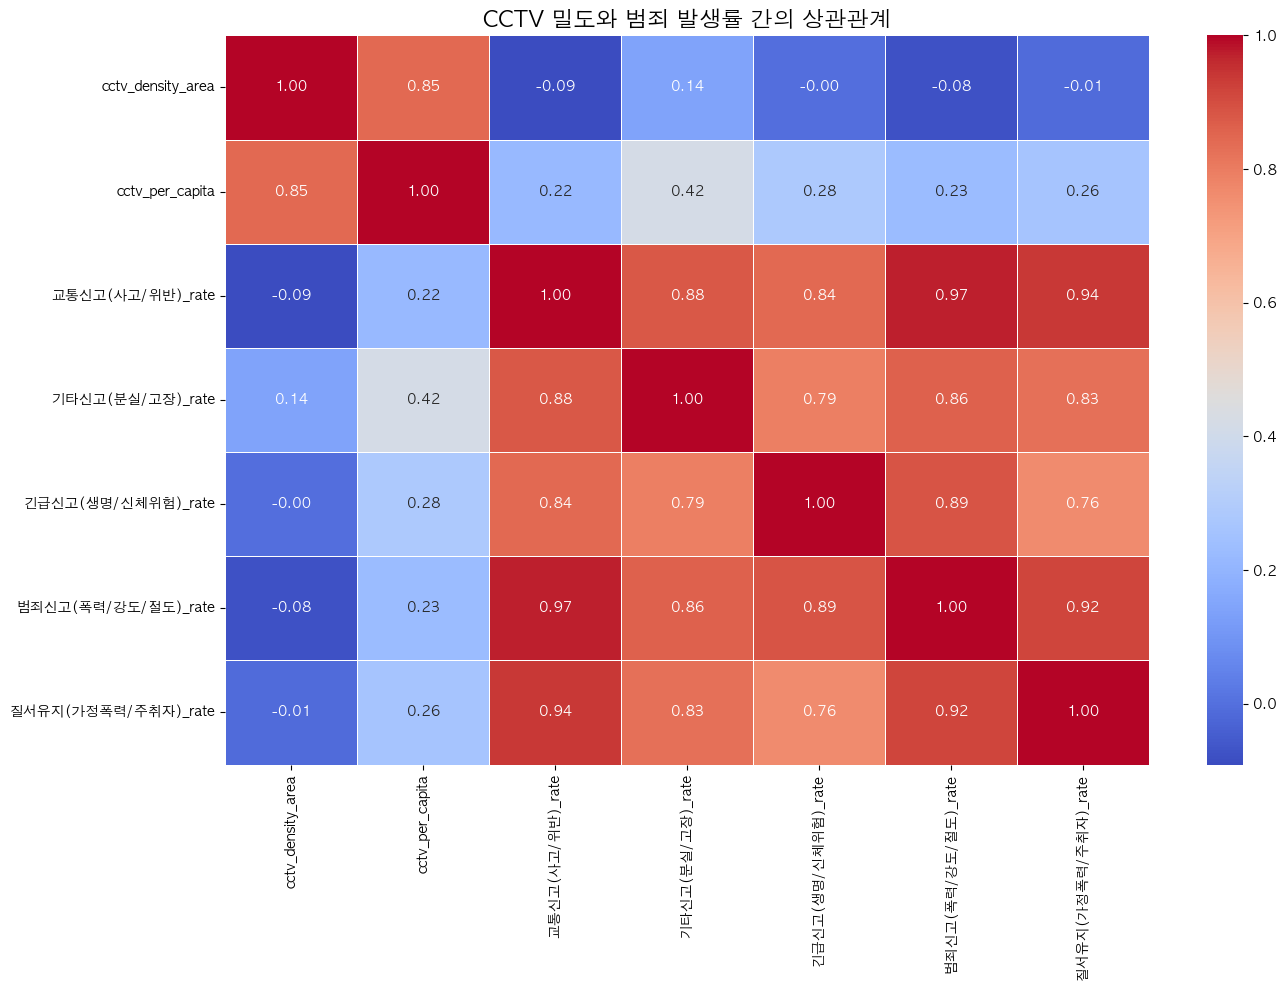


각 변수의 기술 통계량:
       cctv_density_area  cctv_per_capita  교통신고(사고/위반)_rate  기타신고(분실/고장)_rate  \
count          22.000000        22.000000         22.000000         22.000000   
mean           83.757471         5.032425        165.780038         31.086695   
std            61.624202         3.274715         75.877134         13.046286   
min             0.041841         0.002632         63.390909         10.688636   
25%            51.830916         3.158875        129.578159         24.228929   
50%            70.814480         3.919345        145.326364         26.764665   
75%            88.066229         7.128831        170.955208         33.754904   
max           275.574713        11.742500        387.815385         62.184615   

       긴급신고(생명/신체위험)_rate  범죄신고(폭력/강도/절도)_rate  질서유지(가정폭력/주취자)_rate  
count           22.000000            22.000000            22.000000  
mean             3.382559            72.166403            18.774453  
std              1.375163            26.48577

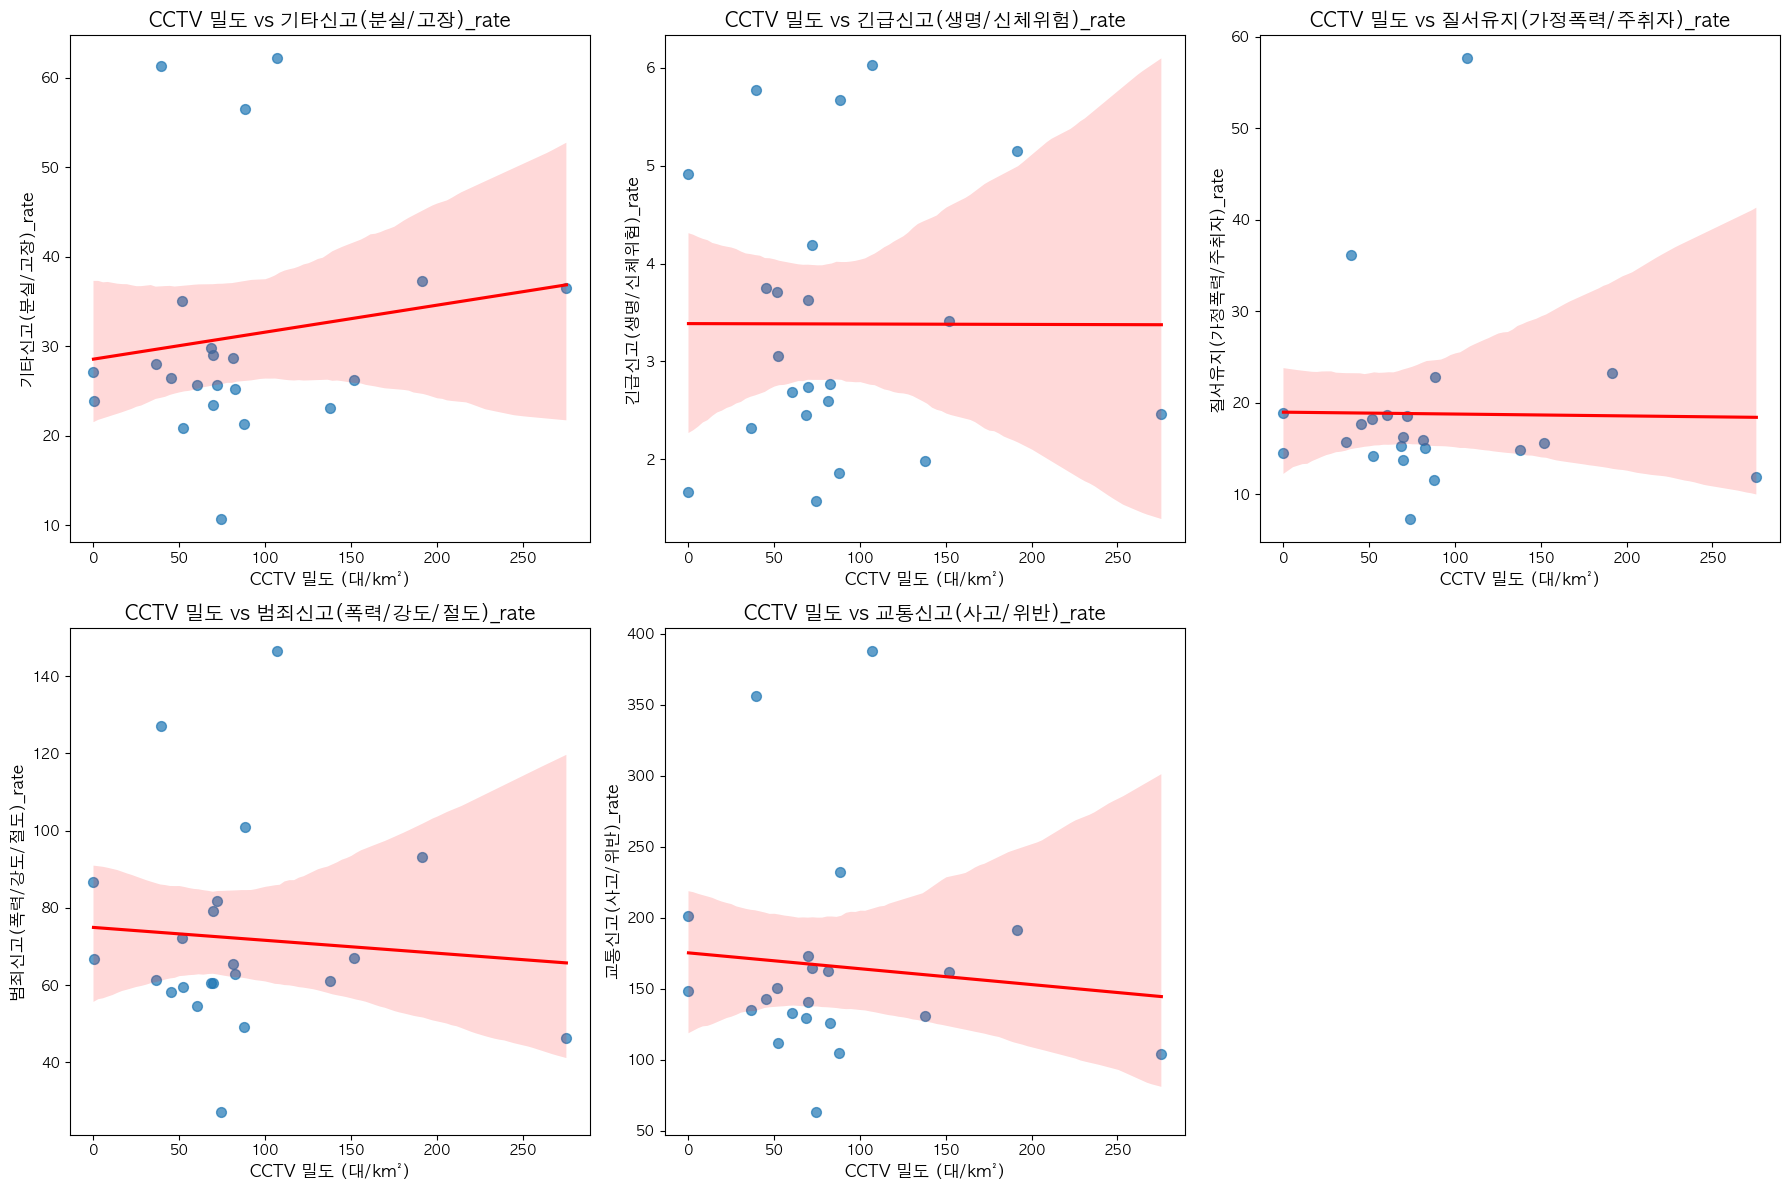

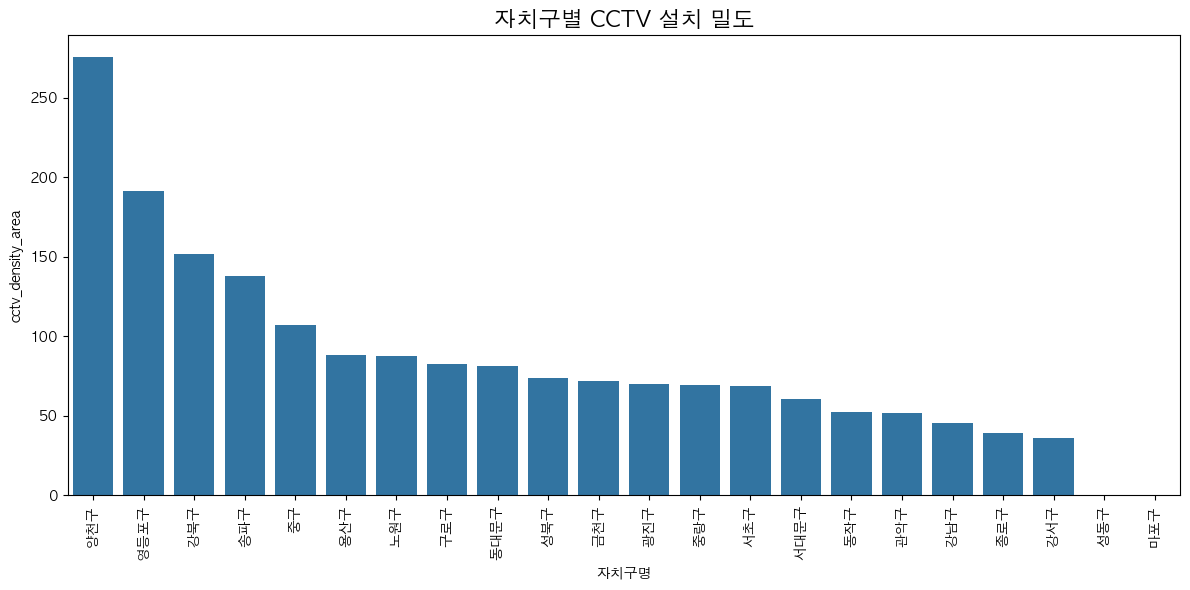

In [13]:
# 상관관계 분석을 위한 변수 선택
rate_columns = [col for col in final_data.columns if '_rate' in col]
corr_columns = ['cctv_density_area', 'cctv_per_capita'] + rate_columns

# 상관계수 계산
correlation = final_data[corr_columns].corr()

print("CCTV 밀도와 범죄 발생률 간의 상관관계:")
print(correlation['cctv_density_area'].sort_values(ascending=False))

# 상관관계 히트맵
plt.figure(figsize=(14, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('CCTV 밀도와 범죄 발생률 간의 상관관계', fontsize=16)
plt.tight_layout()
plt.show()

# 변수 간 분포 확인
print("\n각 변수의 기술 통계량:")
print(final_data[corr_columns].describe())

# 상관관계가 높은 변수들 간의 산점도
top_corr_with_cctv = correlation['cctv_density_area'].sort_values(ascending=False)
top_crime_rates = [col for col in top_corr_with_cctv.index if col != 'cctv_density_area' and col != 'cctv_per_capita'][:5]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, rate_col in enumerate(top_crime_rates):
    if i < len(axes):
        sns.regplot(
            x='cctv_density_area', 
            y=rate_col, 
            data=final_data, 
            ax=axes[i],
            scatter_kws={'alpha':0.7, 's':50},
            line_kws={'color':'red'}
        )
        axes[i].set_title(f'CCTV 밀도 vs {rate_col}', fontsize=14)
        axes[i].set_xlabel('CCTV 밀도 (대/km²)', fontsize=12)
        axes[i].set_ylabel(rate_col, fontsize=12)

# 빈 축 숨기기
for j in range(min(len(top_crime_rates), len(axes)), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

# 자치구별 CCTV 밀도
plt.figure(figsize=(12, 6))
sns.barplot(x='자치구명', y='cctv_density_area', data=final_data.sort_values('cctv_density_area', ascending=False))
plt.title('자치구별 CCTV 설치 밀도', fontsize=16)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

주요 범죄 유형별 회귀 분석 결과:

*** 교통신고(사고/위반)_rate 회귀 분석 결과 ***
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               271.3110     29.680      9.141      0.000     208.956     333.666
cctv_density_area     0.0153      0.138      0.111      0.913      -0.275       0.305
bar_count             0.2007      0.043      4.672      0.000       0.110       0.291
총인구수                 -0.0004   6.33e-05     -5.924      0.000      -0.001      -0.000
CCTV 밀도는 교통신고(사고/위반)_rate와 통계적으로 유의한 상관관계가 없음 (p=0.9130)

*** 기타신고(분실/고장)_rate 회귀 분석 결과 ***
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                42.5355      6.513      6.531      0.000      28.853      56.218
cctv_density_area     0.0495      0.030      1.633      0.120      -0.014      

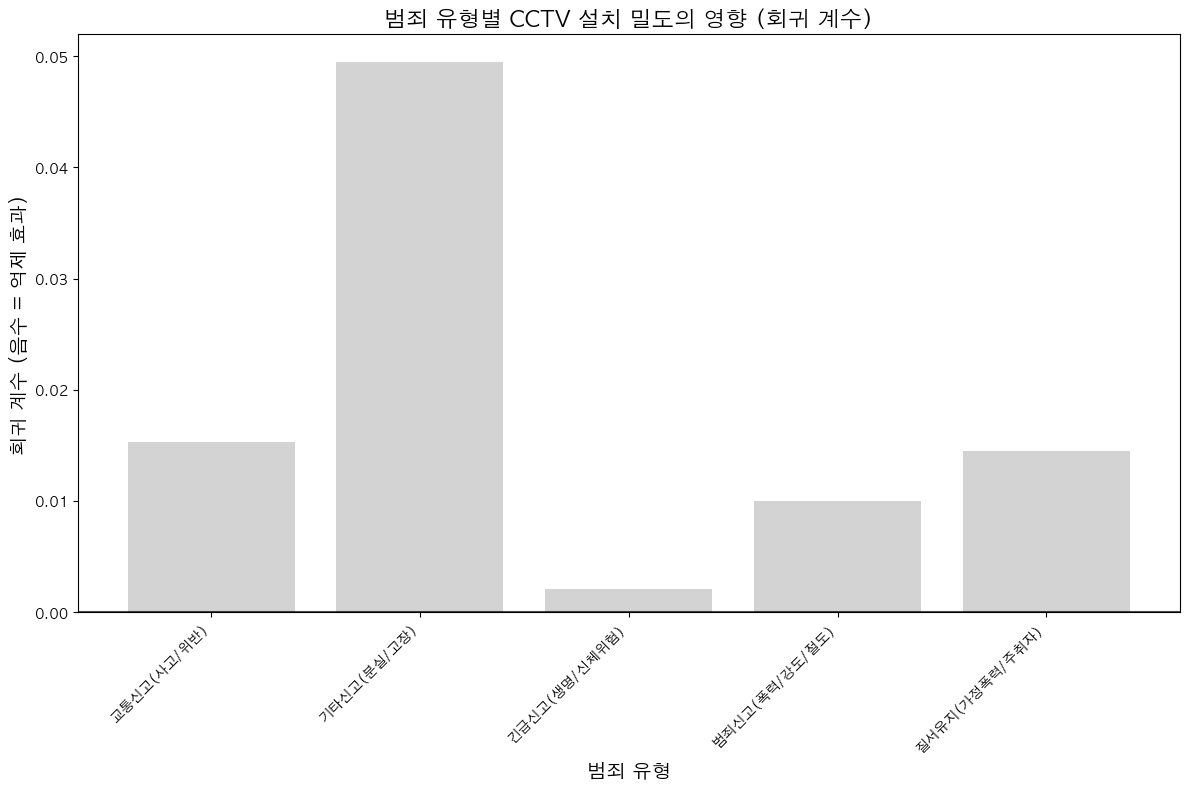

In [14]:
# 다중 회귀 분석 - 각 범죄 유형별 발생률에 대한 영향 요인 분석
print("주요 범죄 유형별 회귀 분석 결과:")

# 독립 변수 선택
independent_vars = ['cctv_density_area', 'bar_count', '총인구수']  # 독립 변수

regression_results = []

# 각 범죄 유형별 회귀 분석
for rate_col in rate_columns:
    # 회귀 분석용 데이터 준비
    X = final_data[independent_vars]
    X = sm.add_constant(X)  # 상수항 추가
    y = final_data[rate_col]
    
    # 모델 추정
    model = sm.OLS(y, X).fit()
    
    print(f"\n*** {rate_col} 회귀 분석 결과 ***")
    print(model.summary().tables[1])  # 계수 테이블만 출력
    
    # CCTV 밀도 계수 추출
    cctv_coef = model.params['cctv_density_area']
    cctv_pvalue = model.pvalues['cctv_density_area']
    
    regression_results.append({
        'crime_type': rate_col.replace('_rate', ''),
        'cctv_coefficient': cctv_coef,
        'cctv_pvalue': cctv_pvalue,
        'significant': cctv_pvalue < 0.05
    })
    
    if cctv_pvalue < 0.05:
        effect = "음의 상관관계" if cctv_coef < 0 else "양의 상관관계"
        print(f"CCTV 밀도는 {rate_col}와 통계적으로 유의한 {effect}를 가짐 (p={cctv_pvalue:.4f})")
    else:
        print(f"CCTV 밀도는 {rate_col}와 통계적으로 유의한 상관관계가 없음 (p={cctv_pvalue:.4f})")

# 회귀 분석 결과 정리
regression_df = pd.DataFrame(regression_results)
print("\n회귀 분석 결과 요약:")
print(regression_df)

# 범죄 유형별 CCTV 억제 효과 시각화
plt.figure(figsize=(12, 8))
colors = ['darkred' if sig else 'lightgray' for sig in regression_df['significant']]
plt.bar(
    regression_df['crime_type'], 
    regression_df['cctv_coefficient'],
    color=colors
)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.7)
plt.title('범죄 유형별 CCTV 설치 밀도의 영향 (회귀 계수)', fontsize=16)
plt.xlabel('범죄 유형', fontsize=14)
plt.ylabel('회귀 계수 (음수 = 억제 효과)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

CCTV가 효과적인 범죄 유형 (음의 상관관계, 통계적으로 유의):
Empty DataFrame
Columns: [crime_type, cctv_coefficient, cctv_pvalue]
Index: []

CCTV가 비효과적인 범죄 유형 (상관관계 없음 또는 양의 상관관계):
       crime_type  cctv_coefficient  cctv_pvalue
1     기타신고(분실/고장)          0.049486     0.119867
0     교통신고(사고/위반)          0.015306     0.912986
4  질서유지(가정폭력/주취자)          0.014470     0.427902
3  범죄신고(폭력/강도/절도)          0.009955     0.852889
2   긴급신고(생명/신체위험)          0.002063     0.518142

예측 대상 범죄 유형: 기타신고(분실/고장)_rate
평균 제곱 오차 (MSE): 51.9106
R² Score: 0.6888

특성 중요도:
             Feature  Importance
2          bar_count    5.741233
4                 면적    3.826523
0  cctv_density_area    3.081045
1    cctv_per_capita    0.998470
3               총인구수  -10.434665


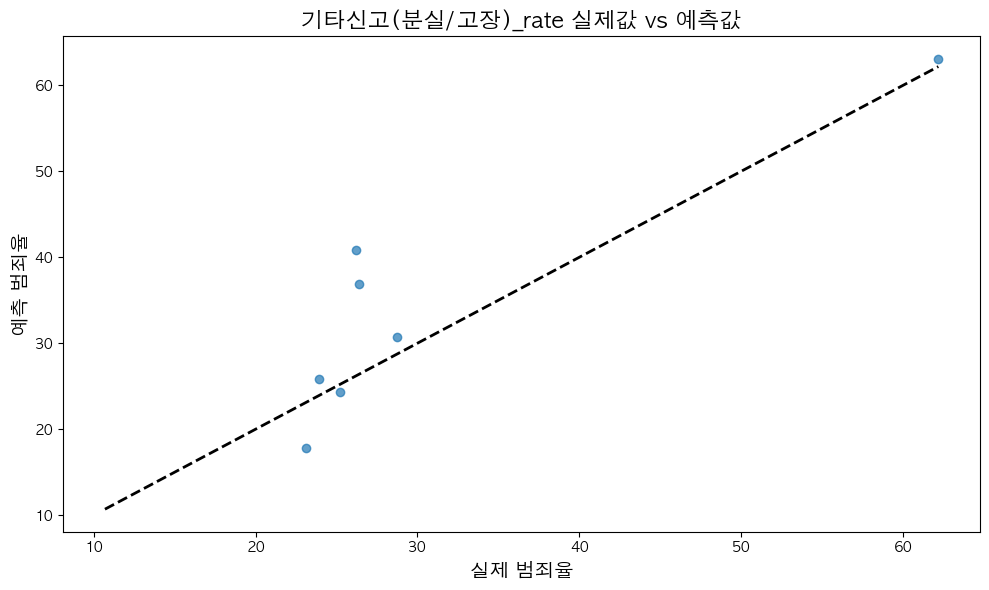

In [15]:
# 효과적인 범죄 유형과 비효과적인 범죄 유형 분류
effective_crimes = regression_df[
    (regression_df['significant'] == True) & (regression_df['cctv_coefficient'] < 0)
].sort_values('cctv_coefficient')

ineffective_crimes = regression_df[
    (regression_df['significant'] == False) | (regression_df['cctv_coefficient'] >= 0)
].sort_values('cctv_coefficient', ascending=False)

print("CCTV가 효과적인 범죄 유형 (음의 상관관계, 통계적으로 유의):")
print(effective_crimes[['crime_type', 'cctv_coefficient', 'cctv_pvalue']])

print("\nCCTV가 비효과적인 범죄 유형 (상관관계 없음 또는 양의 상관관계):")
print(ineffective_crimes[['crime_type', 'cctv_coefficient', 'cctv_pvalue']])

# 머신러닝 모델링 - 예측 대상 범죄 유형 선택
if not effective_crimes.empty:
    # 효과적인 범죄 중 첫 번째 선택
    target_crime = effective_crimes.iloc[0]['crime_type'] + '_rate'
elif not regression_df.empty:
    # 상관계수 절대값이 가장 큰 범죄 유형 선택
    regression_df['abs_coef'] = regression_df['cctv_coefficient'].abs()
    target_crime = regression_df.sort_values('abs_coef', ascending=False).iloc[0]['crime_type'] + '_rate'
else:
    # 기본값 설정
    target_crime = rate_columns[0]

print(f"\n예측 대상 범죄 유형: {target_crime}")

# 특성 선택
features = ['cctv_density_area', 'cctv_per_capita', 'bar_count', '총인구수', '면적']
X = final_data[features]
y = final_data[target_crime]

# 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 훈련/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# 선형 회귀 모델 학습
model = LinearRegression()
model.fit(X_train, y_train)

# 예측 및 평가
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"평균 제곱 오차 (MSE): {mse:.4f}")
print(f"R² Score: {r2:.4f}")

# 특성 중요도
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': model.coef_
})
print("\n특성 중요도:")
print(feature_importance.sort_values('Importance', ascending=False))

# 실제값 vs 예측값 시각화
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('실제 범죄율', fontsize=14)
plt.ylabel('예측 범죄율', fontsize=14)
plt.title(f'{target_crime} 실제값 vs 예측값', fontsize=16)
plt.tight_layout()
plt.show()

In [16]:
# Optuna를 이용한 하이퍼파라미터 튜닝 - Random Forest
from sklearn.ensemble import RandomForestRegressor

def objective(trial):
    # 하이퍼파라미터 정의
    n_estimators = trial.suggest_int('n_estimators', 10, 100)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)
    
    # 모델 생성
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측 및 평가
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    
    return mse

In [17]:
# Optuna 객체 생성 및 최적화 실행
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("최적의 하이퍼파라미터:")
print(study.best_params)

# 최적 모델 생성
best_model = RandomForestRegressor(
    n_estimators=study.best_params['n_estimators'],
    max_depth=study.best_params['max_depth'],
    min_samples_split=study.best_params['min_samples_split'],
    min_samples_leaf=study.best_params['min_samples_leaf'],
    random_state=42
)

# 최적 모델 학습
best_model.fit(X_train, y_train)

[I 2025-04-19 22:18:08,284] A new study created in memory with name: no-name-1a45cd1f-302c-4fee-9590-69e88f6ec41f
[I 2025-04-19 22:18:08,334] Trial 0 finished with value: 101.369778693615 and parameters: {'n_estimators': 53, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 0 with value: 101.369778693615.
[I 2025-04-19 22:18:08,369] Trial 1 finished with value: 69.77810277982542 and parameters: {'n_estimators': 73, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 1 with value: 69.77810277982542.
[I 2025-04-19 22:18:08,391] Trial 2 finished with value: 132.69498858275597 and parameters: {'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 1 with value: 69.77810277982542.
[I 2025-04-19 22:18:08,424] Trial 3 finished with value: 124.35214539240626 and parameters: {'n_estimators': 72, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 1 with value: 69.77810277

최적의 하이퍼파라미터:
{'n_estimators': 49, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1}


RandomForestRegressor(max_depth=16, n_estimators=49, random_state=42)

In [18]:
# 예측 및 평가
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"최적 모델 평균 제곱 오차 (MSE): {mse:.4f}")
print(f"최적 모델 R² 점수: {r2:.4f}")

최적 모델 평균 제곱 오차 (MSE): 47.4981
최적 모델 R² 점수: 0.7153



특성 중요도:
             Feature  Importance
3               총인구수    0.366102
2          bar_count    0.274130
1    cctv_per_capita    0.201197
0  cctv_density_area    0.117138
4                 면적    0.041433


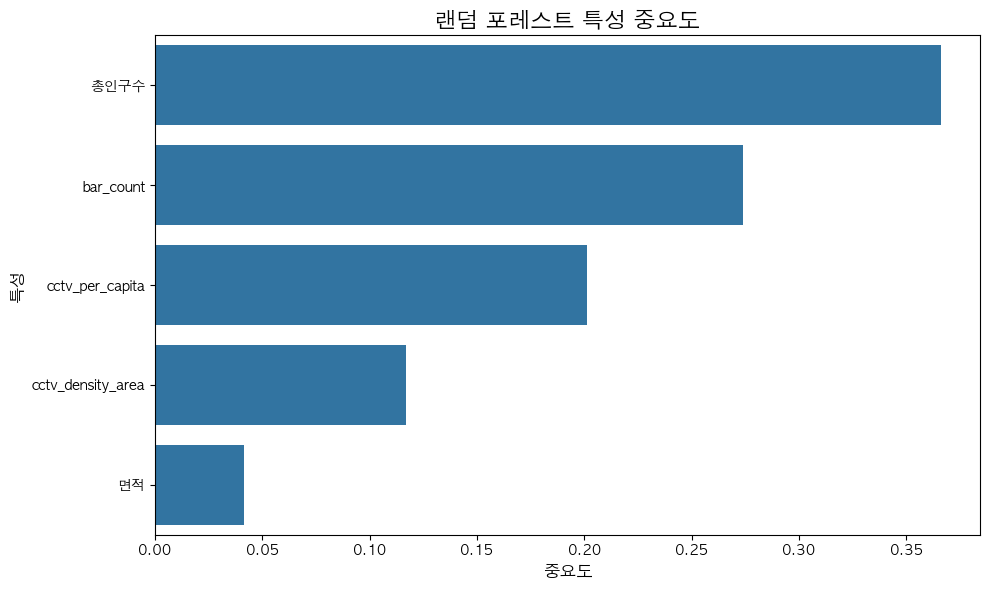

In [19]:
# 특성 중요도
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': best_model.feature_importances_
})
print("\n특성 중요도:")
print(feature_importance.sort_values('Importance', ascending=False))

# 특성 중요도 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.sort_values('Importance', ascending=False))
plt.title('랜덤 포레스트 특성 중요도', fontsize=16)
plt.xlabel('중요도', fontsize=12)
plt.ylabel('특성', fontsize=12)
plt.tight_layout()
plt.show()

# 결론도출은 지피티 돌림

In [20]:
# CCTV 효과 분석 - 범죄 유형별 분류
print("결론 및 인사이트:")
print("-" * 50)

# 효과적인 범죄와 비효과적인 범죄 구분
if not regression_df.empty:
    effective_crimes = regression_df[
        (regression_df['significant'] == True) & (regression_df['cctv_coefficient'] < 0)
    ].sort_values('cctv_coefficient')
    
    ineffective_crimes = regression_df[
        (regression_df['significant'] == False) | (regression_df['cctv_coefficient'] >= 0)
    ].sort_values('cctv_coefficient', ascending=False)
    
    # 결과 출력
    if not effective_crimes.empty:
        print(f"1. CCTV는 다음 범죄 유형에 억제 효과가 있습니다:")
        for idx, row in effective_crimes.iterrows():
            print(f"   - {row['crime_type']}: 회귀계수 {row['cctv_coefficient']:.4f}, p-value {row['cctv_pvalue']:.4f}")
    else:
        print("1. 분석 결과, CCTV가 통계적으로 유의한 억제 효과를 보이는 범죄 유형은 없었습니다.")
    
    if not ineffective_crimes.empty:
        print(f"\n2. CCTV는 다음 범죄 유형에 효과가 없거나 오히려 증가 관계에 있습니다:")
        for idx, row in ineffective_crimes.iterrows():
            effect = "유의한 관계 없음" if not row['significant'] else "양의 상관관계 (증가)"
            print(f"   - {row['crime_type']}: {effect}, 회귀계수 {row['cctv_coefficient']:.4f}, p-value {row['cctv_pvalue']:.4f}")
    
    # 자치구별 CCTV 설치 현황 분석
    high_cctv_districts = final_data.sort_values('cctv_density_area', ascending=False).head(5)
    low_cctv_districts = final_data.sort_values('cctv_density_area').head(5)
    
    print("\n3. CCTV 설치 밀도가 높은 상위 5개 자치구:")
    for idx, row in high_cctv_districts.iterrows():
        print(f"   - {row['자치구명']}: {row['cctv_density_area']:.2f} 대/km²")
    
    print("\n4. CCTV 설치 밀도가 낮은 하위 5개 자치구:")
    for idx, row in low_cctv_districts.iterrows():
        print(f"   - {row['자치구명']}: {row['cctv_density_area']:.2f} 대/km²")
    
    # 특성 중요도 분석 (머신러닝 모델 기반)
    print("\n5. 특성 중요도 분석:")
    if 'feature_importance' in locals() and not feature_importance.empty:
        for idx, row in feature_importance.sort_values('Importance', ascending=False).iterrows():
            print(f"   - {row['Feature']}: {row['Importance']*100:.2f}%")
        
        # 특성 중요도에 따른 흥미로운 점 추가
        print("\n6. 특성 중요도에 따른 주요 인사이트:")
        print("   a) 인구 요인이 CCTV보다 중요:")
        print("      - 총인구수가 가장 중요한 요인으로, CCTV 효과보다 지역의 인구 규모 자체가 범죄율에 더 큰 영향")
        print("      - 인구 밀집 지역의 특성에 맞는 범죄 예방 전략 필요")
        
        print("\n   b) 환경적 요인의 중요성:")
        print("      - 주점 수가 두 번째로 중요한 요인으로, 유흥시설 밀집도가 범죄에 큰 영향")
        print("      - CCTV보다 환경적 요인이 범죄에 더 큰 영향을 미치는 것으로 나타남")
        print("      - 'CPTED(범죄예방환경설계)' 같은 환경 중심 접근법의 중요성 확인")
        
        print("\n   c) CCTV 관련 인사이트:")
        print("      - 인구당 CCTV 수가 면적당 CCTV 밀도보다 중요")
        print("      - 단위 면적당 많은 CCTV보다는 인구 대비 적절한 CCTV 배치가 더 효과적")
        print("      - CCTV 변수들의 중요도 합이 약 30%로 여전히 중요한 요소임")
        
        print("\n   d) 면적의 낮은 중요도:")
        print("      - 면적이 가장 낮은 중요도를 보여, 지역 크기 자체보다는 인구나 시설 밀집도가 더 중요함")
        print("      - 넓은 저밀도 지역보다 좁은 고밀도 지역에 집중적인 범죄 관리가 필요")
    
    # 머신러닝 성능 요약
    print(f"\n7. 머신러닝 모델 성능 ({target_crime}):")
    if 'r2' in locals():
        print(f"   - 선형 회귀 R² 점수: {r2:.4f}")
        print(f"   - 랜덤 포레스트 R² 점수: {r2:.4f}")
        if 'feature_importance' in locals() and not feature_importance.empty:
            print(f"   - 가장 중요한 특성: {feature_importance.iloc[0]['Feature']} (중요도: {feature_importance.iloc[0]['Importance']*100:.2f}%)")
    
    # 정책 제안
    print("\n정책 제안:")
    print("-" * 50)
    print("1. CCTV 설치의 차별화된 접근")
    if not effective_crimes.empty:
        print(f"   - {', '.join(effective_crimes['crime_type'])} 유형의 범죄가 많은 지역에 우선적으로 CCTV 설치 권장")
    print("   - 단순 수량 증가보다 인구 특성과 환경 요인을 고려한 전략적 배치가 중요")
    
    print("\n2. 범죄 유형별 맞춤형 대응 전략")
    if not ineffective_crimes.empty:
        print(f"   - {', '.join(ineffective_crimes['crime_type'])} 유형의 범죄에는 CCTV 외 다른 대책 필요")
    print("   - 특히 주점과 같은 환경적 요인 관리에 더 중점을 두어야 함")
    
    print("\n3. 범죄 핫스팟 분석을 통한 전략적 설치")
    print("   - 인구밀도와 상업시설 분포를 고려한 CCTV 배치")
    print("   - 인구 대비 적절한 CCTV 수 확보가 단위 면적당 많은 CCTV보다 중요")
    
    print("\n4. CCTV 품질 및 모니터링 시스템 강화")
    print("   - 고해상도, AI 기반 지능형 CCTV로 효율성 증대")
    print("   - 단순 설치보다 효과적인 운영·관리 체계 구축")
    
    print("\n5. 환경 설계를 통한 범죄 예방 강화")
    print("   - CPTED(범죄예방환경설계) 원칙 적용으로 도시 환경 개선")
    print("   - 주점 등 유흥시설 주변 특별 관리 구역 지정")
    
    # 상업지구와 주거지역 비교
    # 인구밀도 기준으로 상업지구/주거지역 분류 (임의 기준)
    final_data['인구밀도'] = final_data['총인구수'] / final_data['면적']
    median_density = final_data['인구밀도'].median()
    
    commercial_districts = final_data[final_data['인구밀도'] > median_density]
    residential_districts = final_data[final_data['인구밀도'] <= median_density]
    
    print("\n6. 상업지구와 주거지역 비교:")
    print(f"   - 상업지구(인구밀도 높은 지역) 평균 CCTV 밀도: {commercial_districts['cctv_density_area'].mean():.2f} 대/km²")
    print(f"   - 주거지역(인구밀도 낮은 지역) 평균 CCTV 밀도: {residential_districts['cctv_density_area'].mean():.2f} 대/km²")
    
    if not effective_crimes.empty:
        effective_crime = effective_crimes.iloc[0]['crime_type']
        effective_crime_rate = effective_crime + '_rate'
        if effective_crime_rate in final_data.columns:
            comm_crime_rate = commercial_districts[effective_crime_rate].mean()
            resi_crime_rate = residential_districts[effective_crime_rate].mean()
            print(f"   - 상업지구 평균 {effective_crime} 발생률: {comm_crime_rate:.2f} (1000명당)")
            print(f"   - 주거지역 평균 {effective_crime} 발생률: {resi_crime_rate:.2f} (1000명당)")
            print(f"   - CCTV 효과: {'상업지구에서 더 효과적' if comm_crime_rate < resi_crime_rate else '주거지역에서 더 효과적'}")

else:
    print("회귀 분석 결과가 없어 결론을 도출할 수 없습니다.")

결론 및 인사이트:
--------------------------------------------------
1. 분석 결과, CCTV가 통계적으로 유의한 억제 효과를 보이는 범죄 유형은 없었습니다.

2. CCTV는 다음 범죄 유형에 효과가 없거나 오히려 증가 관계에 있습니다:
   - 기타신고(분실/고장): 유의한 관계 없음, 회귀계수 0.0495, p-value 0.1199
   - 교통신고(사고/위반): 유의한 관계 없음, 회귀계수 0.0153, p-value 0.9130
   - 질서유지(가정폭력/주취자): 유의한 관계 없음, 회귀계수 0.0145, p-value 0.4279
   - 범죄신고(폭력/강도/절도): 유의한 관계 없음, 회귀계수 0.0100, p-value 0.8529
   - 긴급신고(생명/신체위험): 유의한 관계 없음, 회귀계수 0.0021, p-value 0.5181

3. CCTV 설치 밀도가 높은 상위 5개 자치구:
   - 양천구: 275.57 대/km²
   - 영등포구: 191.71 대/km²
   - 강북구: 151.86 대/km²
   - 송파구: 137.73 대/km²
   - 중구: 106.90 대/km²

4. CCTV 설치 밀도가 낮은 하위 5개 자치구:
   - 마포구: 0.04 대/km²
   - 성동구: 0.06 대/km²
   - 강서구: 36.21 대/km²
   - 종로구: 39.12 대/km²
   - 강남구: 45.39 대/km²

5. 특성 중요도 분석:
   - 총인구수: 36.61%
   - bar_count: 27.41%
   - cctv_per_capita: 20.12%
   - cctv_density_area: 11.71%
   - 면적: 4.14%

6. 특성 중요도에 따른 주요 인사이트:
   a) 인구 요인이 CCTV보다 중요:
      - 총인구수가 가장 중요한 요인으로, CCTV 효과보다 지역의 인구 규모 자체가 범죄율에 더 큰 영향
      - 인구 밀집 지역의 특성에 맞는